In [204]:
!pip install pykrx
from pykrx import stock
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

import matplotlib
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

warnings.filterwarnings("ignore")
matplotlib.rcParams['font.family'] ='Malgun Gothic'    
matplotlib.rcParams['axes.unicode_minus'] =False

import math
import keras
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import LSTM, Dense,RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.models import Sequential, Model, load_model 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping 
import pickle as pkl 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.utils import plot_model 
import pydot as pyd 
from keras.utils.vis_utils import plot_model, model_to_dot

# Data Loading
Kepco = stock.get_market_ohlcv_by_date(fromdate="20110101", todate="20211210", ticker="015760")


In [205]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [206]:
Kepco

,시가,고가,저가,종가,거래량
날짜,,,,,
2011-01-03,30400,30450,29800,30050,1261721
2011-01-04,30050,30050,29700,29900,1718372
2011-01-05,29800,29850,29200,29250,2324148
2011-01-06,29350,29650,29050,29050,1930250
2011-01-07,29000,29050,28650,28950,2077771
...,...,...,...,...,...
2021-12-06,21650,21800,21300,21650,967295
2021-12-07,21700,22000,21600,21900,943397
2021-12-08,22000,22450,21950,22200,1645576


In [207]:
log_Kepco = np.log(Kepco)

# Problem
- partition the whole dataset into training dataset and test dataset at 7:3 ratio.
- Perform the followings on the test dataset and provide the Mean squared error (MSE) and mean absolute percentage error (MAPE).
- (1) Predict the one-step ahead closing price using the LSTM model.

- (2) Predict the future 5 days (Open Price, High Price, Low Price, Volume, Closing Price) using standard Seq2Seq Model and Seq2Seq Model with Attention Technique.


# Plotting

### Plotting of Raw Data

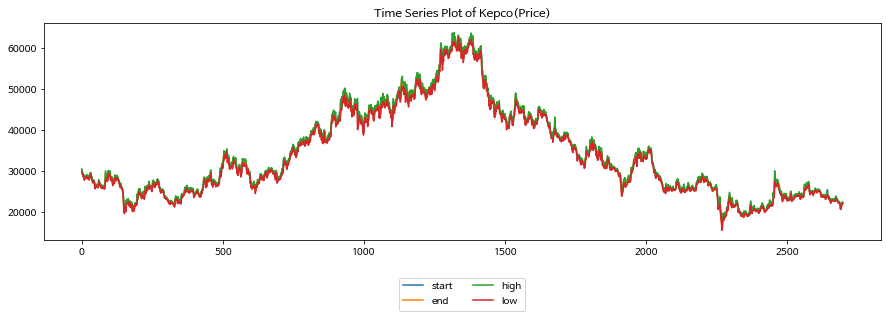

In [208]:
# 비정상 시계열

plt.rc('font', family='NanumBarunGothic') 

# raw data time_series plot

plt.figure(figsize=(15, 4))
plt.plot(range(len(Kepco)), Kepco["시가"], label='start')
plt.plot(range(len(Kepco)), Kepco["종가"], label='end')
plt.plot(range(len(Kepco)), Kepco["고가"], label='high')
plt.plot(range(len(Kepco)), Kepco["저가"], label='low')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.title("Time Series Plot of Kepco(Price)")
plt.show()

### Histogram of Raw Data

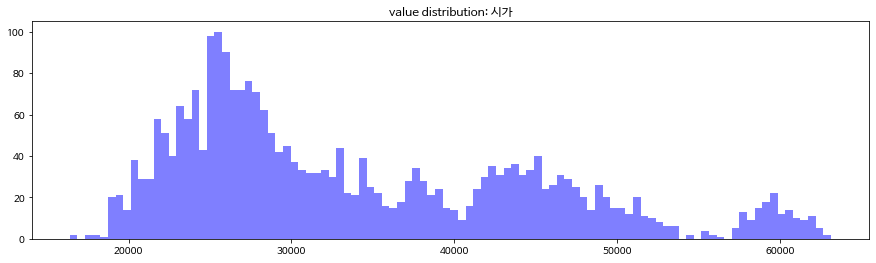

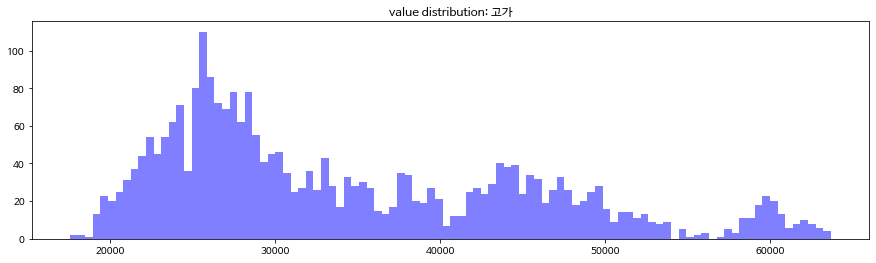

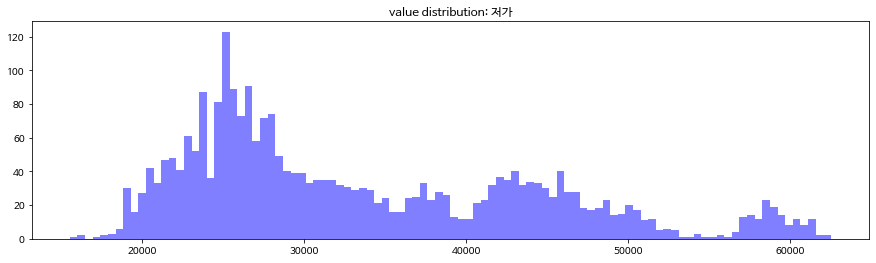

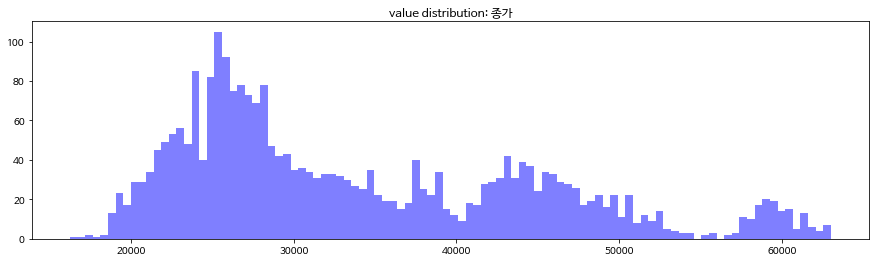

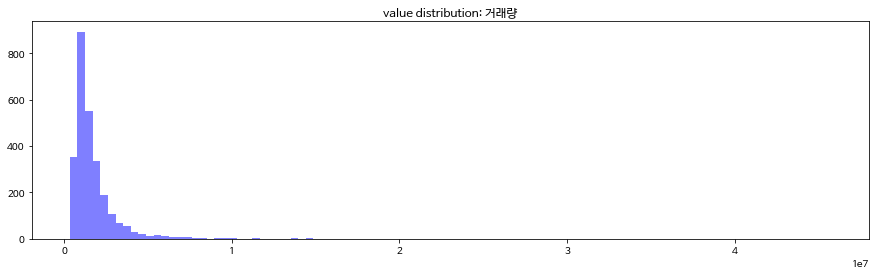

In [209]:
for column in Kepco.columns :
    plt.figure(figsize=(15, 4))
    plt.hist(Kepco[column], bins=100, color='blue', alpha=0.5)
    plt.title('value distribution: '+ column)
    plt.show()

### Plot of log transformation

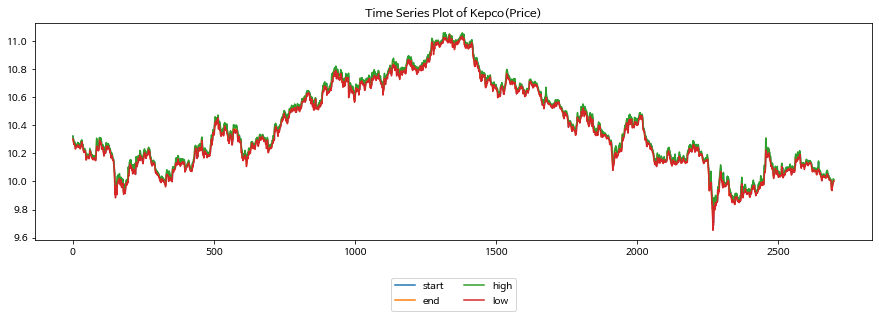

In [210]:
plt.figure(figsize=(15, 4))
plt.plot(range(len(Kepco)), np.log(Kepco["시가"]), label='start')
plt.plot(range(len(Kepco)), np.log(Kepco["종가"]), label='end')
plt.plot(range(len(Kepco)), np.log(Kepco["고가"]), label='high')
plt.plot(range(len(Kepco)), np.log(Kepco["저가"]), label='low')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.title("Time Series Plot of Kepco(Price)")
plt.show()

# 9.6 ~ 11.0

### Histogram of log transformation for Data

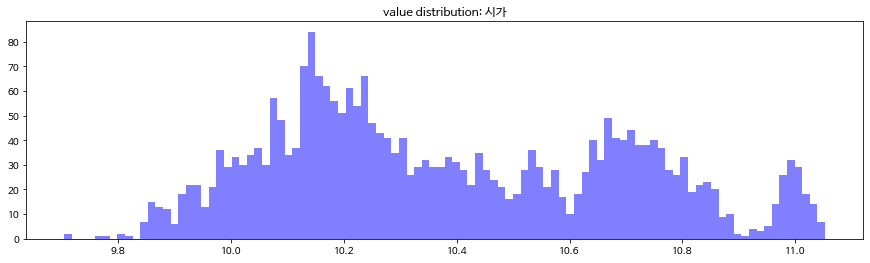

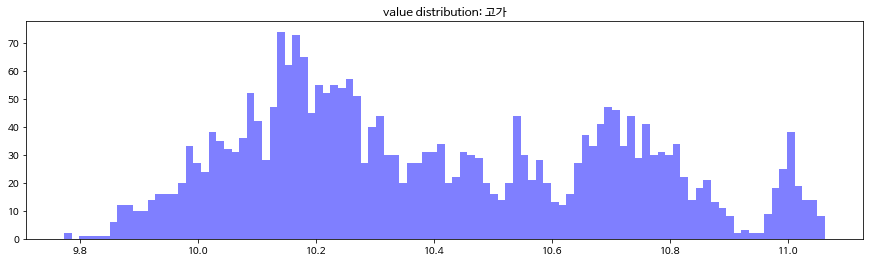

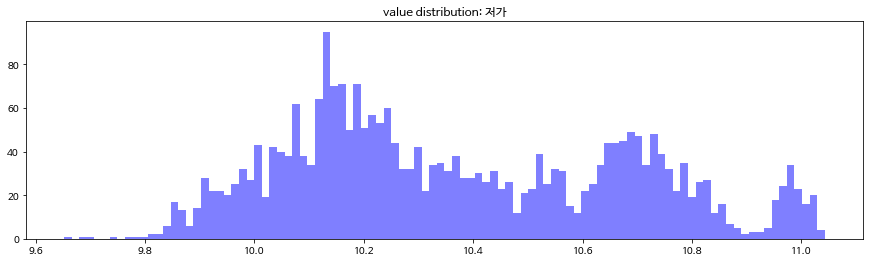

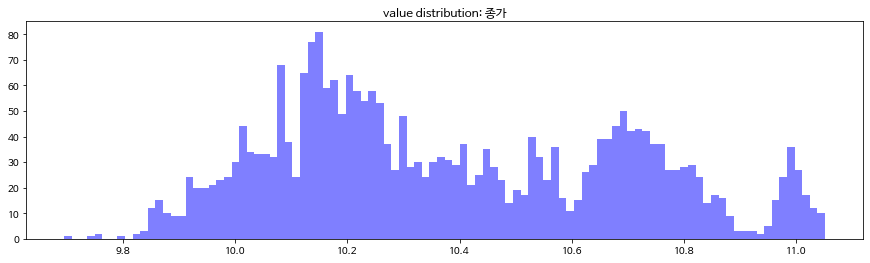

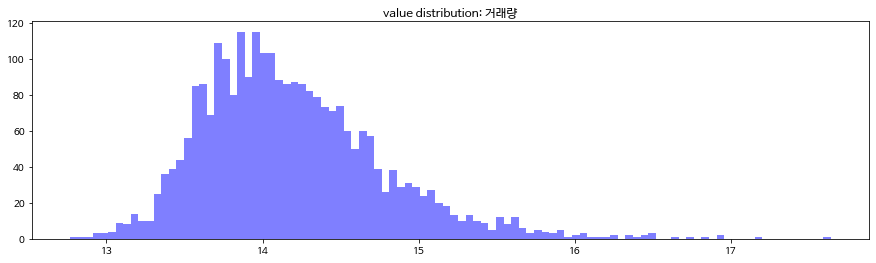

In [211]:
for column in Kepco.columns :
    plt.figure(figsize=(15, 4))
    plt.hist(log_Kepco[column], bins=100, color='blue', alpha=0.5)
    plt.title('value distribution: '+ column)
    plt.show()

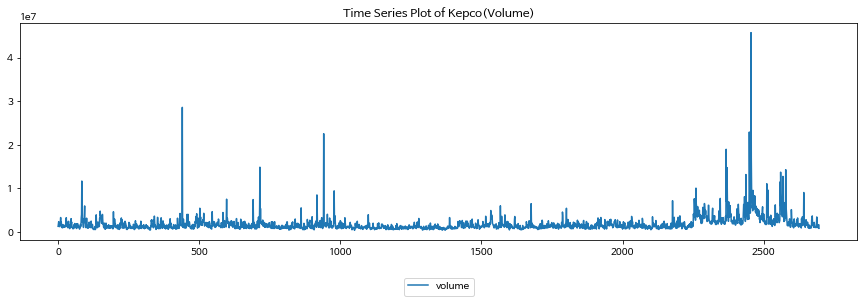

In [212]:
plt.figure(figsize=(15, 4))
plt.plot(range(len(Kepco)), Kepco["거래량"], label='volume')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.title("Time Series Plot of Kepco(Volume)")
plt.show()

### ACF, PACF Plot

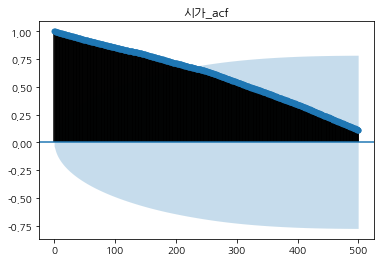

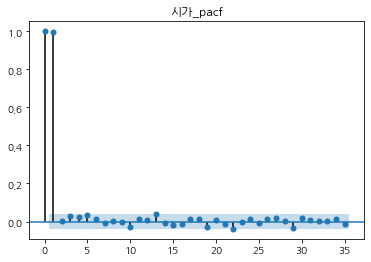

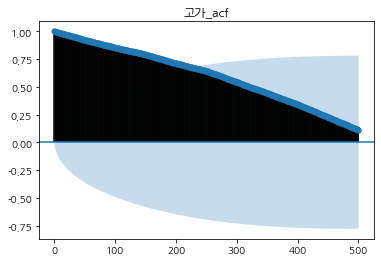

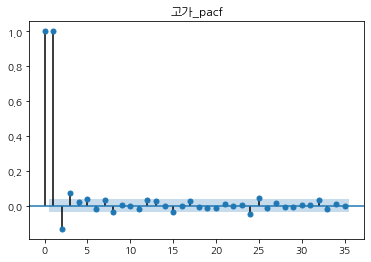

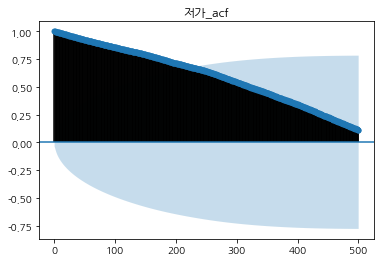

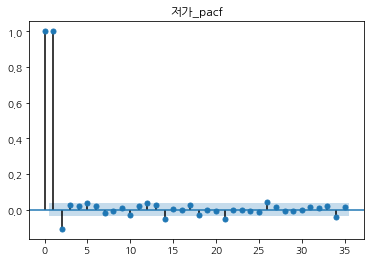

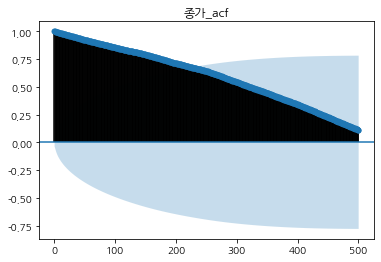

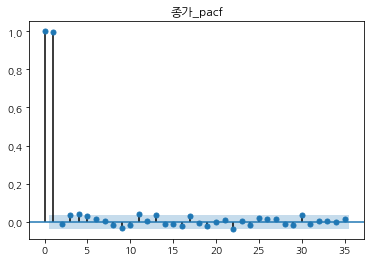

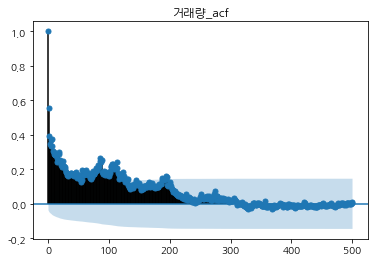

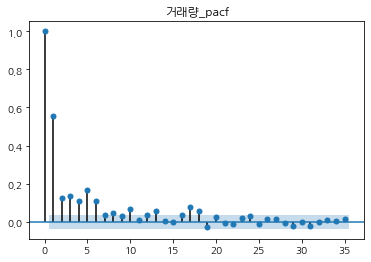

In [213]:
# acf , pacf graph

plt.rc('font', family='NanumGothic')   # restart runtime

for column in Kepco.columns : 
    sm.graphics.tsa.plot_acf(Kepco[column] , lags =  500)
    plt.title(column+str("_acf"))
    plt.show()
    
    sm.graphics.tsa.plot_pacf(Kepco[column])
    plt.title(column+str("_pacf"))
    plt.show()

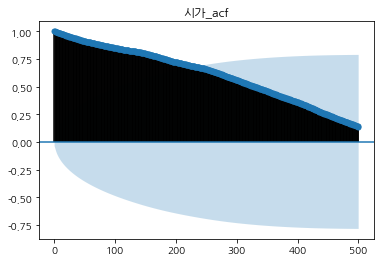

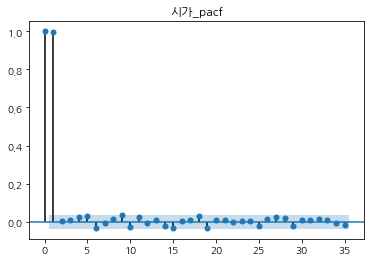

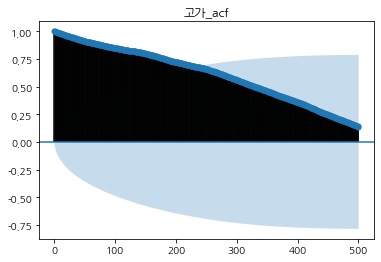

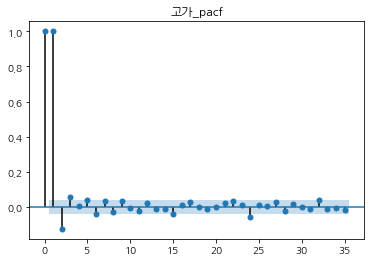

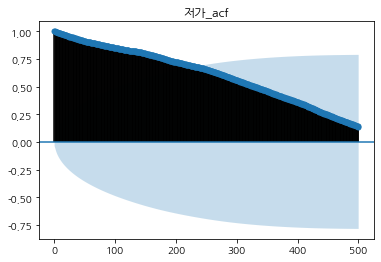

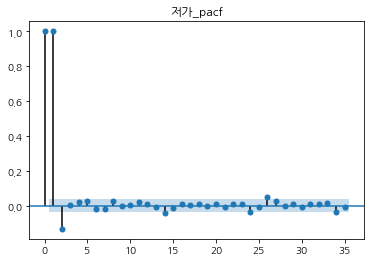

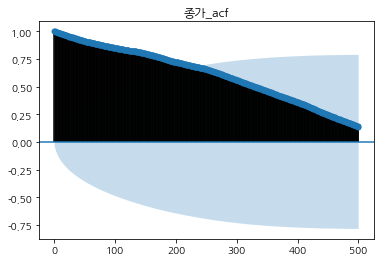

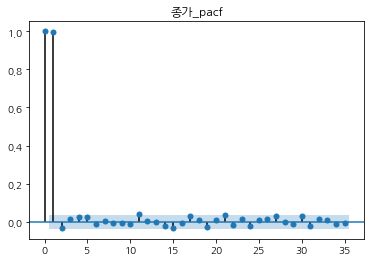

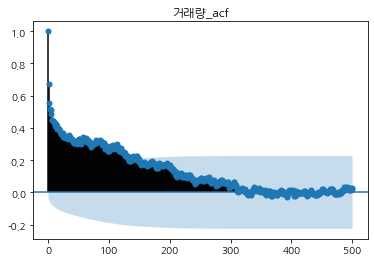

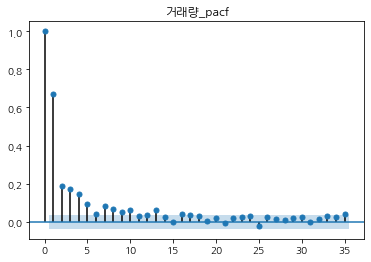

In [214]:
for column in Kepco.columns : 
    sm.graphics.tsa.plot_acf(log_Kepco[column] , lags =  500)
    plt.title(column+str("_acf"))
    plt.show()
    
    sm.graphics.tsa.plot_pacf(log_Kepco[column])
    plt.title(column+str("_pacf"))
    plt.show()

# Train_Test_split

In [215]:
#--- 1. Split sequences to 70% train set and 30% test set
train_ratio = 0.7
train_len = int(train_ratio * Kepco.shape[0])

print(train_len)

1887


# Preprocessing

In [216]:
kepco_array = Kepco.values

kepco_index = np.array(range(len(Kepco)))

kepco_lbl = np.column_stack([kepco_array, kepco_index, [1]*train_len + [0]*(len(kepco_index)-train_len)])

print(kepco_lbl.shape)
print(kepco_lbl)

(2697, 7)
[[  30400   30450   29800 ... 1261721       0       1]
 [  30050   30050   29700 ... 1718372       1       1]
 [  29800   29850   29200 ... 2324148       2       1]
 ...
 [  22000   22450   21950 ... 1645576    2694       0]
 [  22200   22400   22100 ... 1625508    2695       0]
 [  22250   22300   22050 ...  810107    2696       0]]


### Normalization

In [217]:
n_past = 7           # past
n_features = 5       # pred

kepco_train_max = kepco_lbl[kepco_lbl[:, 6] == 1, :n_features].max(axis = 0)
kepco_train_max = kepco_train_max.tolist()+[1]*2

(2697, 7)


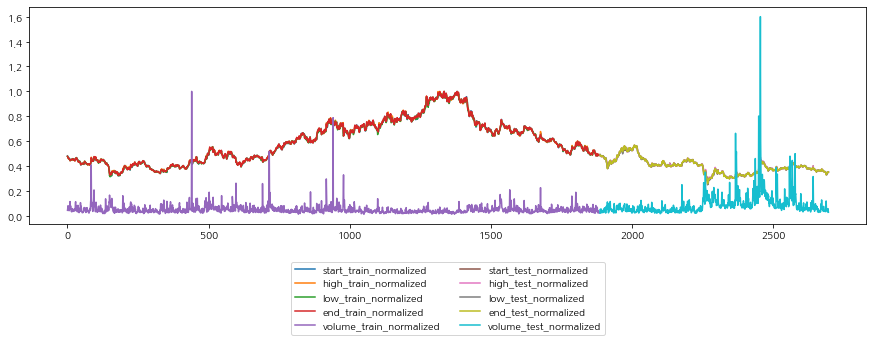

In [218]:
kepco_normalize = np.divide(kepco_lbl, kepco_train_max)
print(kepco_normalize.shape)

plt.figure(figsize=(15, 4))
plt.plot(range(train_len), kepco_normalize[:train_len, 0], label='start_train_normalized')
plt.plot(range(train_len), kepco_normalize[:train_len, 1], label='high_train_normalized')
plt.plot(range(train_len), kepco_normalize[:train_len, 2], label='low_train_normalized')
plt.plot(range(train_len), kepco_normalize[:train_len, 3], label='end_train_normalized')
plt.plot(range(train_len), kepco_normalize[:train_len, 4], label='volume_train_normalized')

plt.plot(range(train_len, len(kepco_normalize)), kepco_normalize[train_len:, 0], label='start_test_normalized')
plt.plot(range(train_len, len(kepco_normalize)), kepco_normalize[train_len:, 1], label='high_test_normalized')
plt.plot(range(train_len, len(kepco_normalize)), kepco_normalize[train_len:, 2], label='low_test_normalized')
plt.plot(range(train_len, len(kepco_normalize)), kepco_normalize[train_len:, 3], label='end_test_normalized')
plt.plot(range(train_len, len(kepco_normalize)), kepco_normalize[train_len:, 4], label='volume_test_normalized')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [219]:
# Simple LSTM

def truncate(x, feature_cols = range(5), target_cols = range(5), label_col = 6, train_len = None, test_len = None) : 
    in_, out_, lbl = [], [], []                         # append 하기 위해 list 로 저장
    for i in range(len(x) - train_len - test_len + 1) : 
        in_.append(x[i : (i+train_len), feature_cols].tolist())                      
        out_.append(x[(i+train_len) : (i+train_len+test_len), target_cols].tolist()) 
        lbl.append(x[i+train_len, label_col])                                        
    return np.array(in_), np.array(out_), np.array(lbl) # list 를 ndarray 형태로 출력

X_in, X_out, lbl = truncate(kepco_normalize, feature_cols = range(5), target_cols = range(5), label_col =6,
                            train_len = n_past, test_len = 1)    

print(X_in.shape, X_out.shape, lbl.shape)

(2690, 7, 5) (2690, 1, 5) (2690,)


In [220]:
X_input_train = X_in[np.where(lbl==1)]    # label = 1 인 값 => train ,X_input_train => train X
X_output_train = X_out[np.where(lbl==1)]  # X_output_train => train_y 값

X_input_test = X_in[np.where(lbl==0)]     # X _ test 
X_output_test = X_out[np.where(lbl==0)]   # y _ test
print(X_input_train.shape, X_output_train.shape) # (1857, 30, 6) (1857, 1, 6)
print(X_input_test.shape, X_output_test.shape)   # (810, 30, 6) (810, 1, 6)

# close price (종가 : 두 번재 컬럼)

(1880, 7, 5) (1880, 1, 5)
(810, 7, 5) (810, 1, 5)


# Modeling _ Simple LSTM

### Training

In [221]:
model = Sequential() 

model.add(LSTM(units = 100, input_shape = (X_input_train.shape[1], n_features)))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ["mae"])

model.summary() 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 100)               42400     
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 42,501
Trainable params: 42,501
Non-trainable params: 0
_________________________________________________________________


In [222]:
X_input_train.shape

(1880, 7, 5)

In [223]:
epc = 100
batch_size = 32

es = EarlyStopping(monitor = "val_loss", mode = "min", patience = 25)

history = model.fit(X_input_train[:, :, :], X_output_train[:, :, :], batch_size=batch_size ,
                    epochs = epc, validation_split=0.2, verbose = 1, callbacks = [es])

Epoch 1/100
47/47 [==============================] - 3s 21ms/step - loss: 0.1054 - mae: 0.2625 - val_loss: 0.0541 - val_mae: 0.2059
Epoch 2/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0816 - mae: 0.2314 - val_loss: 0.0532 - val_mae: 0.1717
Epoch 3/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0785 - mae: 0.2261 - val_loss: 0.0548 - val_mae: 0.1969
Epoch 4/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0780 - mae: 0.2254 - val_loss: 0.0541 - val_mae: 0.1812
Epoch 5/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0777 - mae: 0.2247 - val_loss: 0.0546 - val_mae: 0.1685
Epoch 6/100
47/47 [==============================] - 0s 10ms/step - loss: 0.0771 - mae: 0.2242 - val_loss: 0.0544 - val_mae: 0.1880
Epoch 7/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0768 - mae: 0.2239 - val_loss: 0.0543 - val_mae: 0.1812
Epoch 8/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0774 -

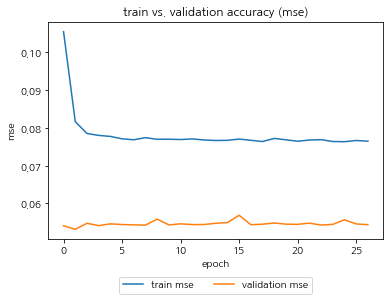

In [224]:
train_mse = history.history["loss"]
valid_mse = history.history["val_loss"]

plt.plot(train_mse, label='train mse')
plt.plot(valid_mse, label='validation mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mse)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

### Prediction

In [225]:
# 예측값
train_pred = model.predict(X_input_train[:, :, :]) * kepco_train_max[:5] # x_train_max(정규화 수행) 로 나누어 주었기 때문에 다시 곱해준다
test_pred = model.predict(X_input_test[:, :, :]) * kepco_train_max[:5]   # model.predict(X_input_test[:, :, :n_features])
print(train_pred.shape, test_pred.shape)

# 실제값
train_true = X_output_train[:, :, :] * kepco_train_max[:5]
test_true = X_output_test[:, :, :] * kepco_train_max[:5]
print(train_true.shape, test_true.shape)

(1880, 5) (810, 5)
(1880, 1, 5) (810, 1, 5)


In [226]:
train_true = train_true.reshape(-1, 5)
test_true = test_true.reshape(-1, 5)

print(train_true.shape)
print(test_true.shape)

(1880, 5)
(810, 5)


### Close Price Evaluation

In [227]:
Close_train_pred, Close_test_pred, Close_train_true, Close_test_true = train_pred[:, 2] ,  test_pred[:, 2], train_true[:, 2], test_true[:, 2]

In [228]:
from sklearn.metrics import mean_squared_error 
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    

print("MAE of Simple LSTM :", mean_squared_error(Close_test_true, Close_test_pred))
print("MAPE of Simple LSTM: ",  MAPE(Close_test_true, Close_test_pred))

MAE of Simple LSTM : 44964373.40134088
MAPE of Simple LSTM:  26.59030169258201


# Modeling_Seq2Seq_LSTM

In [229]:
X_input_train.shape

(1880, 7, 5)

In [230]:
X_in, X_out, lbl = truncate(kepco_normalize, feature_cols = range(5), target_cols = range(5), label_col = 6,
                            train_len = n_past, test_len = 5)

In [231]:
X_input_train = X_in[np.where(lbl==1)]    # label = 1 인 값 => train ,X_input_train => train X
X_output_train = X_out[np.where(lbl==1)]  # X_output_train => train_y 값

X_input_test = X_in[np.where(lbl==0)]     # X _ test 
X_output_test = X_out[np.where(lbl==0)]   # y _ test

print(X_input_train.shape, X_output_train.shape) 
print(X_input_test.shape, X_output_test.shape)   

(1880, 7, 5) (1880, 5, 5)
(806, 7, 5) (806, 5, 5)


In [232]:
n_hidden = 100

# input layer
input_train = Input(shape = (X_input_train.shape[1], X_input_train.shape[2]))   
output_train = Input(shape = (X_output_train.shape[1], X_output_train.shape[2]))

print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 7, 5), dtype=tf.float32, name='input_11'), name='input_11', description="created by layer 'input_11'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 5), dtype=tf.float32, name='input_12'), name='input_12', description="created by layer 'input_12'")


In [233]:
encdoer_last_h1, encoder_last_h2, encoder_last_c = LSTM(n_hidden, activation = "elu", dropout = 0.2, recurrent_dropout = 0.2,
                                                        return_sequences = False, return_state = True)(input_train) # return_state = True, input_train = X_train

print(encdoer_last_h1) # shape=(None, 100)
print(encoder_last_h2) # shape=(None, 100)
print(encoder_last_c)  # shape=(None, 100)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_17/strided_slice_3:0', description="created by layer 'lstm_17'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_17/while:4', description="created by layer 'lstm_17'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_17/while:5', description="created by layer 'lstm_17'")


In [234]:
encdoer_last_h1 = BatchNormalization(momentum=0.6)(encdoer_last_h1)
encoder_last_c  = BatchNormalization(momentum=0.6)(encoder_last_c)

In [235]:
decoder = RepeatVector(output_train.shape[1])(encoder_last_h2) # output_train.shape[1] : y_train 의 timesteps (몇 시차) # encoder 의 last_hidden_state 를 output_train.shape[1] 만큼 만든다. 
decoder = LSTM(n_hidden, activation = "elu", dropout = 0.2, recurrent_dropout=0.2,
               return_sequences = True, return_state = False)(decoder, initial_state = [encoder_last_h2, encoder_last_c]) # initial_state => encoder 의 마지막 hidden_state, cell_state

print(decoder) # (20, 100) = (output_train.shape[1] , n_hidden)

KerasTensor(type_spec=TensorSpec(shape=(None, 5, 100), dtype=tf.float32, name=None), name='lstm_18/transpose_1:0', description="created by layer 'lstm_18'")


In [236]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder) # 출력은 (20, 2) (x1, x2 에 대해서)
print(out)

# 20, 2 = (output_train.shape[1] = timesteps, output_train.shape[2] = n_features)

KerasTensor(type_spec=TensorSpec(shape=(None, 5, 5), dtype=tf.float32, name=None), name='time_distributed_5/Reshape_1:0', description="created by layer 'time_distributed_5'")


In [237]:
# input_train = Input(shape = (X_input_train.shape[1], X_input_train.shape[2] - 1))
# out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
from tensorflow.keras.models import Model

model = Model(inputs = input_train, outputs = out) # optimizer|
opt = Adam(lr = 0.01, clipnorm = 1)
model.compile(loss = 'mean_squared_error', optimizer = opt, metrics = ["mae"]) 
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 7, 5)]       0           []                               
                                                                                                  
 lstm_17 (LSTM)                 [(None, 100),        42400       ['input_11[0][0]']               
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector_5 (RepeatVector)  (None, 5, 100)      0           ['lstm_17[0][1]']                
                                                                                            

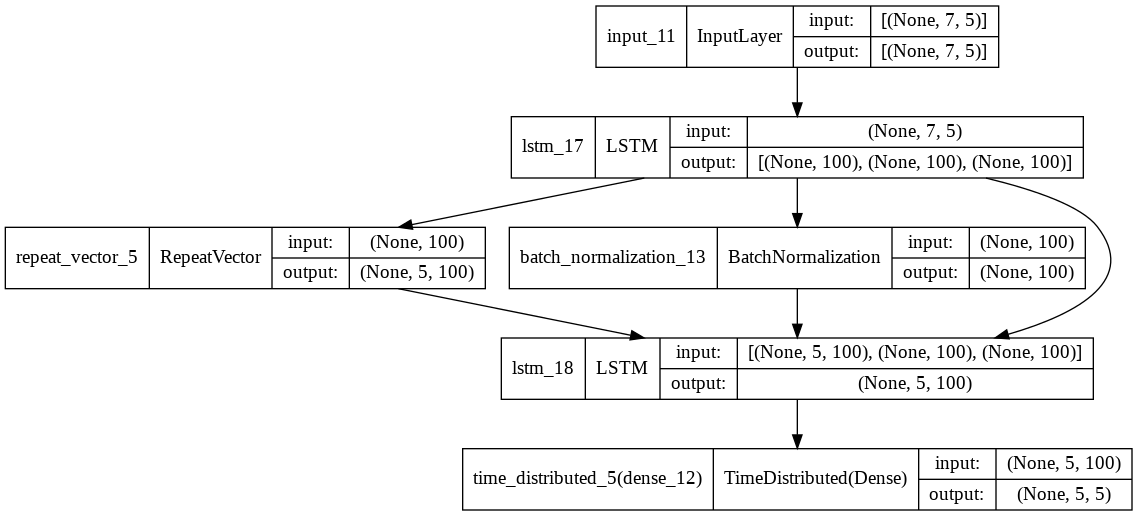

In [238]:
plot_model(model, to_file = "model_plot.png", show_shapes = True, show_layer_names=True)

### Training

In [239]:
# epc = 100 

es = EarlyStopping(monitor = "val_loss", mode = "min", patience = 25)
history = model.fit(X_input_train[:, :, :], X_output_train[:, :, :], validation_split = 0.2, batch_size = batch_size,
                    epochs = epc, verbose = 1, callbacks = [es])

train_mse = history.history["loss"]
valid_mse = history.history["val_loss"]

model.save("model_forecasting_seq2seq.h5")

Epoch 1/100
47/47 [==============================] - 7s 43ms/step - loss: 0.0258 - mae: 0.0959 - val_loss: 0.0020 - val_mae: 0.0335
Epoch 2/100
47/47 [==============================] - 1s 29ms/step - loss: 0.0035 - mae: 0.0435 - val_loss: 0.0044 - val_mae: 0.0580
Epoch 3/100
47/47 [==============================] - 1s 29ms/step - loss: 0.0031 - mae: 0.0409 - val_loss: 6.2100e-04 - val_mae: 0.0189
Epoch 4/100
47/47 [==============================] - 1s 29ms/step - loss: 0.0031 - mae: 0.0413 - val_loss: 9.8773e-04 - val_mae: 0.0252
Epoch 5/100
47/47 [==============================] - 1s 29ms/step - loss: 0.0029 - mae: 0.0394 - val_loss: 7.5773e-04 - val_mae: 0.0219
Epoch 6/100
47/47 [==============================] - 1s 30ms/step - loss: 0.0034 - mae: 0.0427 - val_loss: 0.0109 - val_mae: 0.0930
Epoch 7/100
47/47 [==============================] - 1s 29ms/step - loss: 0.0031 - mae: 0.0398 - val_loss: 0.0042 - val_mae: 0.0576
Epoch 8/100
47/47 [==============================] - 1s 29ms/ste

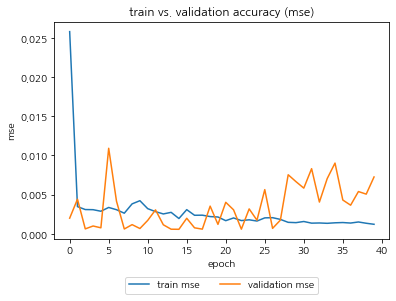

In [240]:
plt.plot(train_mse, label='train mse'), 
plt.plot(valid_mse, label='validation mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mse)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

### Prediction

In [241]:
# 예측값
train_pred = model.predict(X_input_train[:, :, :]) * kepco_train_max[:5] # x_train_max(정규화 수행) 로 나누어 주었기 때문에 다시 곱해준다
test_pred = model.predict(X_input_test[:, :, :]) * kepco_train_max[:5]   # model.predict(X_input_test[:, :, :n_features])
print(train_pred.shape, test_pred.shape)

# 실제값
train_true = X_output_train[:, :, :] * kepco_train_max[:5]
test_true = X_output_test[:, :, :] * kepco_train_max[:5]
print(train_true.shape, test_true.shape)

(1880, 5, 5) (806, 5, 5)
(1880, 5, 5) (806, 5, 5)


In [242]:
data_final = dict() # 딕셔너리를 만든다

for dt, lb in zip([train_pred, train_true, test_pred, test_true], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    
    data_final[lb] = dt
    
    print(lb+': {}'.format(data_final[lb].shape))

train_pred: (1880, 5, 5)
train_true: (1880, 5, 5)
test_pred: (806, 5, 5)
test_true: (806, 5, 5)


### Evaluation

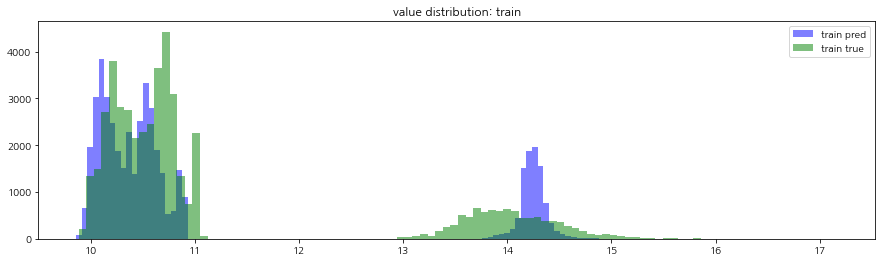

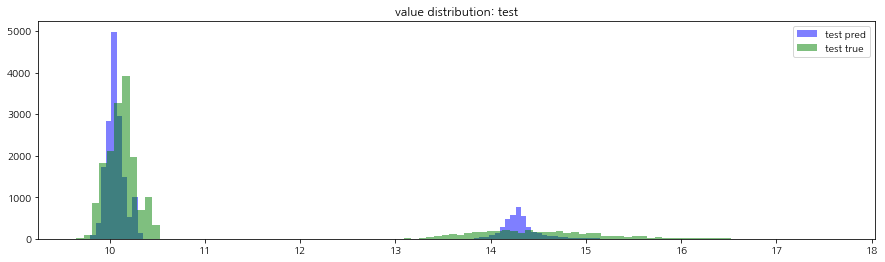

In [243]:
# Check if the prediction value distribution is reasonable
# train, test 에 대한 히스토그램 출력

for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(np.log(data_final[lb+'_pred'].flatten()), bins=100, color='blue', alpha=0.5, label=lb+' pred')
    plt.hist(np.log(data_final[lb+'_true'].flatten()), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

train MAE 125042.4340173841
train MSE 278309748749.5863
train MAPE 20.22954078718378


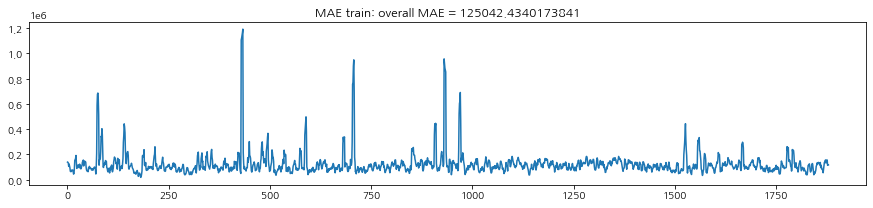

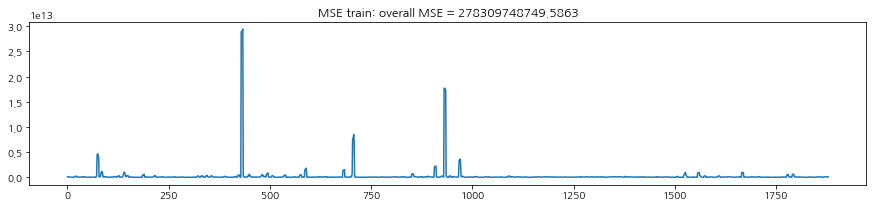

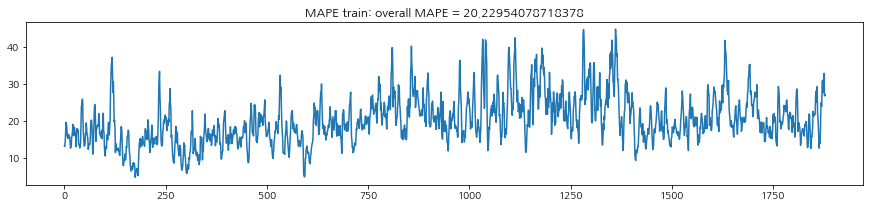

test MAE 255473.77864207
test MSE 1544982159237.3835
test MAPE 14.38709587276609


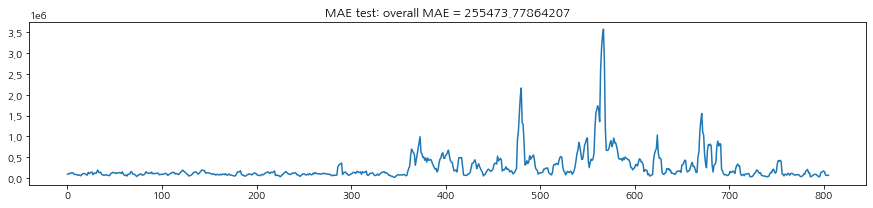

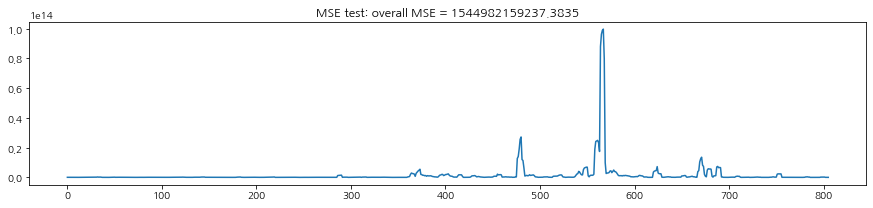

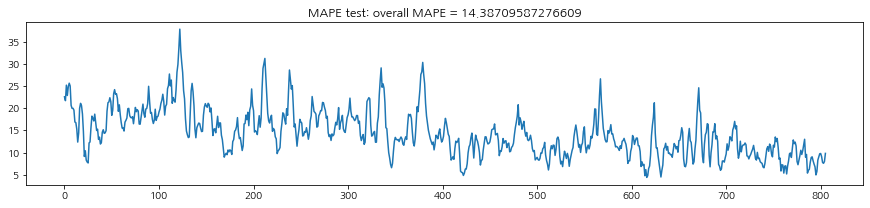

In [244]:
# 모델 성능 평가

for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()     
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2)) 
    print(lb ,"MAE", MAE_overall)

    MSE_overall = ((data_final[lb+'_true'] - data_final[lb+'_pred'])**2).mean()
    MSE_ = ((data_final[lb+'_true'] - data_final[lb+'_pred'])**2).mean(axis = (1, 2))
    print(lb ,"MSE", MSE_overall)

    MAPE_overall = abs((data_final[lb+'_true'] - data_final[lb+'_pred']) / data_final[lb+'_true']).mean() * 100   
    MAPE_ = abs((data_final[lb+'_true'] - data_final[lb+'_pred']) / data_final[lb+'_true']).mean(axis =(1,2)) * 100 
    print(lb ,"MAPE", MAPE_overall)

    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

    plt.figure(figsize=(15, 3))
    plt.plot(MSE_)
    plt.title('MSE '+lb+': overall MSE = '+str(MSE_overall))
    plt.show()


    plt.figure(figsize=(15, 3))
    plt.plot(MAPE_)
    plt.title('MAPE '+lb+': overall MAPE = '+str(MAPE_overall))
    plt.show()

# Seq2Seq Model with Attention Technique.

In [245]:
n_hidden = 100
input_train = Input(shape = (X_input_train.shape[1], X_input_train.shape[2]))
output_train = Input(shape = (X_output_train.shape[1], X_output_train.shape[2]))

In [246]:
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 7, 100), dtype=tf.float32, name=None), name='lstm_19/transpose_1:0', description="created by layer 'lstm_19'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_19/while:4', description="created by layer 'lstm_19'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_19/while:5', description="created by layer 'lstm_19'")


In [247]:
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h) # 마지막 은닉 상태
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c) # 마지막 셀 상태

In [248]:
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 5, 100), dtype=tf.float32, name=None), name='repeat_vector_6/Tile:0', description="created by layer 'repeat_vector_6'")


In [249]:
decoder_stack_h = LSTM(n_hidden, activation = "elu", dropout = 0.2, recurrent_dropout=0.2, 
                       return_state = False, return_sequences = True)(decoder_input, initial_state = [encoder_last_h, encoder_last_c])
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 5, 100), dtype=tf.float32, name=None), name='lstm_20/transpose_1:0', description="created by layer 'lstm_20'")


In [250]:
attention = dot([decoder_stack_h, encoder_stack_h], axes = [2,2]) # decoder_stack_h, encoder_stack_h 곱 , axes = [2, 2]
attention = Activation("softmax")(attention)                      # soft max apply
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 5, 7), dtype=tf.float32, name=None), name='activation_2/Softmax:0', description="created by layer 'activation_2'")


In [251]:
context = dot([attention, encoder_stack_h], axes = [2,1])
context = BatchNormalization(momentum = 0.6)(context)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 5, 100), dtype=tf.float32, name=None), name='batch_normalization_16/batchnorm/add_1:0', description="created by layer 'batch_normalization_16'")


In [252]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 5, 200), dtype=tf.float32, name=None), name='concatenate_2/concat:0', description="created by layer 'concatenate_2'")


In [253]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 5, 5), dtype=tf.float32, name=None), name='time_distributed_6/Reshape_1:0', description="created by layer 'time_distributed_6'")


In [254]:
model = Model(inputs = input_train, outputs = out)
opt = Adam(lr = 0.01, clipnorm = 1)
model.compile(loss = "mean_squared_error", optimizer = opt, metrics = ["mae"])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 7, 5)]       0           []                               
                                                                                                  
 lstm_19 (LSTM)                 [(None, 7, 100),     42400       ['input_13[0][0]']               
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 batch_normalization_14 (BatchN  (None, 100)         400         ['lstm_19[0][1]']                
 ormalization)                                                                              

### Training

In [255]:
epc = 100 

es = EarlyStopping(monitor = "val_loss", mode = "min", patience = 25)
history = model.fit(X_input_train[:, :, :], X_output_train[:, :, :], validation_split = 0.2, batch_size = batch_size, 
                    epochs = epc, verbose = 1, callbacks = [es])

train_mae = history.history["loss"]
valid_mae = history.history["val_loss"]

model.save("model_forecasting_seq2seq.h6")

Epoch 1/100
47/47 [==============================] - 7s 45ms/step - loss: 0.1022 - mae: 0.1541 - val_loss: 0.0014 - val_mae: 0.0301
Epoch 2/100
47/47 [==============================] - 1s 31ms/step - loss: 0.0044 - mae: 0.0506 - val_loss: 0.0013 - val_mae: 0.0292
Epoch 3/100
47/47 [==============================] - 2s 32ms/step - loss: 0.0035 - mae: 0.0449 - val_loss: 7.1120e-04 - val_mae: 0.0199
Epoch 4/100
47/47 [==============================] - 1s 32ms/step - loss: 0.0037 - mae: 0.0461 - val_loss: 7.1004e-04 - val_mae: 0.0210
Epoch 5/100
47/47 [==============================] - 1s 31ms/step - loss: 0.0039 - mae: 0.0481 - val_loss: 0.0013 - val_mae: 0.0288
Epoch 6/100
47/47 [==============================] - 1s 31ms/step - loss: 0.0034 - mae: 0.0444 - val_loss: 0.0014 - val_mae: 0.0270
Epoch 7/100
47/47 [==============================] - 1s 32ms/step - loss: 0.0037 - mae: 0.0461 - val_loss: 0.0025 - val_mae: 0.0429
Epoch 8/100
47/47 [==============================] - 1s 30ms/step - 

INFO:tensorflow:Assets written to: model_forecasting_seq2seq.h6/assets


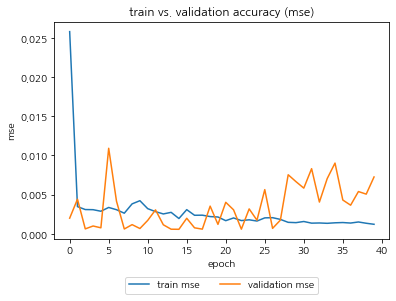

In [256]:
plt.plot(train_mse, label='train mse'), 
plt.plot(valid_mse, label='validation mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mse)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

### Prediction

In [257]:
# inverse transformation of Normalization

# 예측값
train_pred = model.predict(X_input_train[:, :, :]) * kepco_train_max[:5] 
test_pred = model.predict(X_input_test[:, :, :]) * kepco_train_max[:5]   
print(train_pred.shape, test_pred.shape)

# 실제값
train_true = X_output_train[:, :, :] * kepco_train_max[:5]
test_true = X_output_test[:, :, :] * kepco_train_max[:5]
print(train_true.shape, test_true.shape)

(1880, 5, 5) (806, 5, 5)
(1880, 5, 5) (806, 5, 5)


In [258]:
data_final = dict() # 딕셔너리를 만든다

for dt, lb in zip([train_pred, train_true, test_pred, test_true], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    
    data_final[lb] = dt
    
    print(lb+': {}'.format(data_final[lb].shape))

train_pred: (1880, 5, 5)
train_true: (1880, 5, 5)
test_pred: (806, 5, 5)
test_true: (806, 5, 5)


### Evaluation

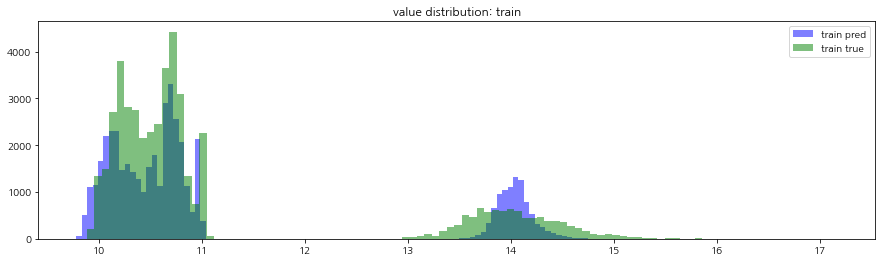

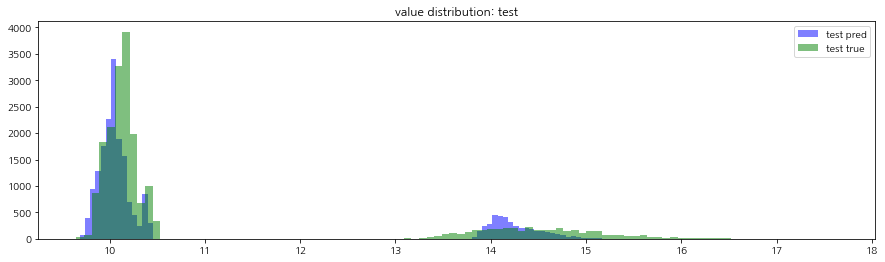

In [259]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(np.log(data_final[lb+'_pred'].flatten()), bins=100, color='blue', alpha=0.5, label=lb+' pred')
    plt.hist(np.log(data_final[lb+'_true'].flatten()), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

train MAE 104455.092536207
train MSE 277064078062.4424
train MAPE 11.040188611460373


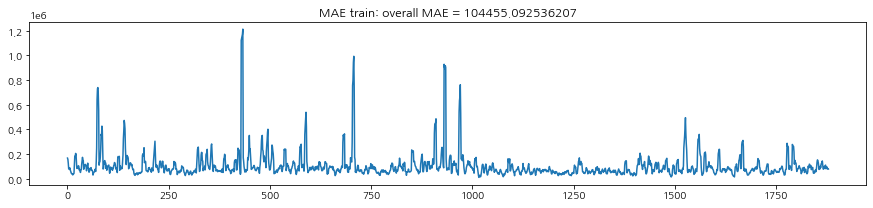

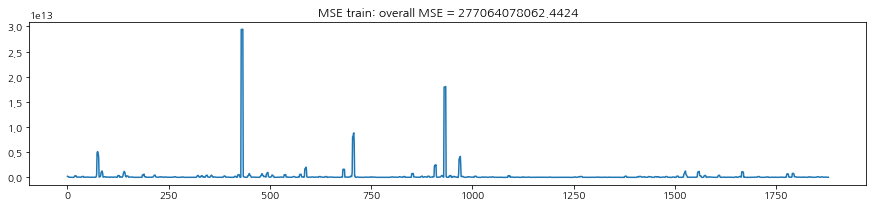

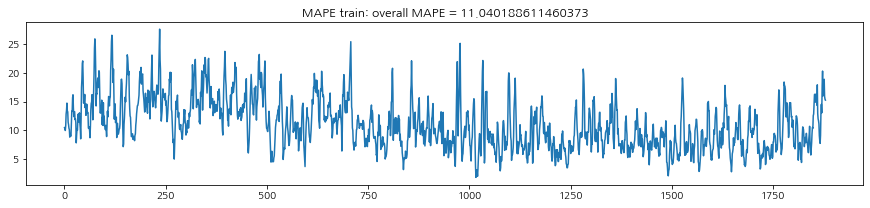

test MAE 242223.40057126898
test MSE 1531030684206.1948
test MAPE 13.21122746562254


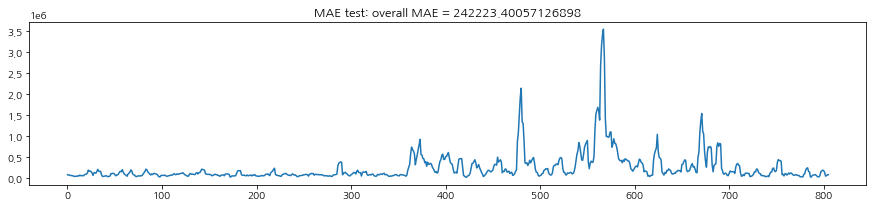

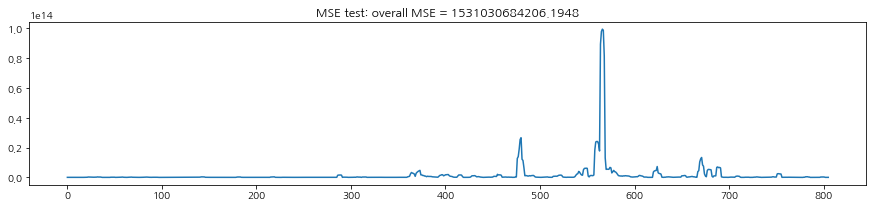

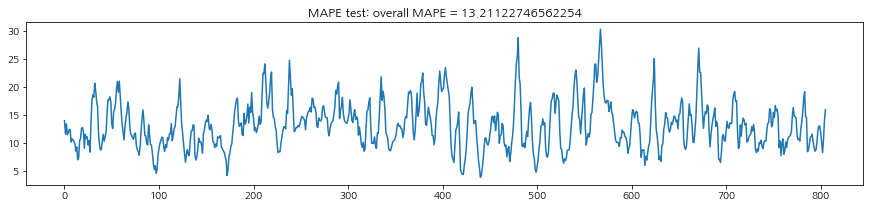

In [260]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()     
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2)) 
    print(lb ,"MAE", MAE_overall)

    MSE_overall = ((data_final[lb+'_true'] - data_final[lb+'_pred'])**2).mean()
    MSE_ = ((data_final[lb+'_true'] - data_final[lb+'_pred'])**2).mean(axis = (1, 2))
    print(lb ,"MSE", MSE_overall)

    MAPE_overall = abs((data_final[lb+'_true'] - data_final[lb+'_pred']) / data_final[lb+'_true']).mean() * 100 
    MAPE_ = abs((data_final[lb+'_true'] - data_final[lb+'_pred']) / data_final[lb+'_true']).mean(axis =(1,2)) * 100 
    print(lb ,"MAPE", MAPE_overall)

    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

    plt.figure(figsize=(15, 3))
    plt.plot(MSE_)
    plt.title('MSE '+lb+': overall MSE = '+str(MSE_overall))
    plt.show()


    plt.figure(figsize=(15, 3))
    plt.plot(MAPE_)
    plt.title('MAPE '+lb+': overall MAPE = '+str(MAPE_overall))
    plt.show()

# Result

- Evaluation

|Model|MSE|MAPE|
|---|---|---|
|Simple LSTM|44964373.40|26.59|
|Standard Seq2Seq|1544982159237.38|14.38|
|Seq2Seq with Attention|1531030684206.19|13.21|